# Import packages

In [102]:
print('Importing packages...')
import os
import pandas
import numpy as np
import time
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import geopandas
import scipy.stats
from pprint import pprint

thisdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
data_dir = thisdir + 'final_data/'
figdir = thisdir + 'figures_final/'

baltimore_shapefile_basedir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'

latest_year = 2018

# ANALYSIS OPTIONS
sb_jobs_lower_limit = 10
pop_lower_limit = 1000
tol = 8100  # Tolerance for declaring a tract is contained in a city council district
summary = {}


# MAPPING OPTIONS
scale = 1
thecolormap = 'viridis'
show_tract_labels = True
show_plot_labels = True

g = 0

print('ok')

Importing packages...
ok


# Pick city

In [103]:
s = time.time()
city = 'Baltimore'

if (city == 'Cleveland'):
    projection = {'init': 'EPSG:3734'}
elif (city == 'Baltimore' or city == 'Washington DC'):
    projection = {'init': 'EPSG:6487'}
elif (city == 'Detroit'):
    projection = {'init': 'EPSG:2253'}
elif (city == 'Newark'):
    projection = {'init': 'EPSG:3424'}
    
e = time.time()
g = g + (e-s)
print('Selected {0:}!'.format(city))

Selected Baltimore!


# Get raw data

In [104]:
s = time.time()
print('loading data...')
raw_data_gdf = geopandas.read_file(data_dir+'{0:}.shp'.format(city.lower().replace(' ', '_')))
#raw_data_gdf = raw_data_gdf.set_index(['COUNTYFP','NAME','year'])
#raw_data_gdf.columns.tolist()

print('fixing column names...')
columns_df = pandas.read_csv(data_dir+'{0:}_no_geo.csv'.format(city.lower().replace(' ', '_')), nrows=1)
columns_df = columns_df.drop("Unnamed: 0", axis=1)
#columns_df = columns_df.set_index(['COUNTYFP','NAME','year'])

column_names = columns_df.columns.tolist() + ['geometry']
raw_data_gdf.columns = column_names

print('setting index...')
raw_data_gdf = raw_data_gdf.rename(columns={'COUNTYFP': 'county', 'NAME': 'census_tract'})
raw_data_gdf = raw_data_gdf.set_index(['county','census_tract','year'])

e = time.time()
g = g + (e-s)
print('Done in {0:,.1f} seconds!'.format(e-s))
raw_data_gdf.head(1).T

loading data...
fixing column names...
setting index...
Done in 0.5 seconds!


county,510
census_tract,101.0
year,2017
city_name,Baltimore
msa,12580
loan_type,4
action_taken_type,1
income_group_code,13
...,...
INTPTLON,-076.5745793
split_county_indicator,N


creating summary data frame...
summing columns...
adding CRA info columns...
adding jobs columns...
copying latest year's demographics values...


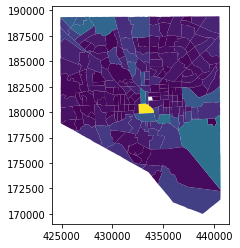

In [105]:
s = time.time()

print('creating summary data frame...')
data_df = pandas.DataFrame(data=None, index=raw_data_gdf.xs(latest_year, level='year').index)

print('summing columns...')
sum_columns = []
#sum_columns += ['county', 'census_tract']
sum_columns += ['nLoans1', 'amtLoans1_adj', 'nLoans100k', 'amtLoans100k_adj', 'nLoans250k', 'amtLoans250k_adj']
sum_columns += ['nLoansToSmallest', 'amtLoansToSmallest_adj', 'nLoans', 'amtLoans_adj']
sum_columns += ['nWorkingLoans', 'amtWorkingLoans_adj']
sum_columns += ['nLoans1_per_totaljob', 'amtLoans1_per_totaljob_adj']
sum_columns += ['nLoans100k_per_totaljob', 'amtLoans100k_per_totaljob_adj']
sum_columns += ['nLoans250k_per_totaljob', 'amtLoans250k_per_totaljob_adj']
sum_columns += ['nLoansToSmallest_per_totaljob', 'amtLoansToSmallest_per_totaljob_adj']
sum_columns += ['nLoans_per_totaljob', 'amtLoans_per_totaljob_adj']
sum_columns += ['nWorkingLoans_per_totaljob', 'amtWorkingLoans_per_totaljob_adj']
sum_columns += ['nLoans1_per_sbjob', 'amtLoans1_per_sbjob_adj']
sum_columns += ['nLoans100k_per_sbjob', 'amtLoans100k_per_sbjob_adj']
sum_columns += ['nLoans250k_per_sbjob', 'amtLoans250k_per_sbjob_adj']
sum_columns += ['nLoansToSmallest_per_sbjob', 'amtLoansToSmallest_per_sbjob_adj']
sum_columns += ['nLoans_per_sbjob', 'amtLoans_per_sbjob_adj']
sum_columns += ['nWorkingLoans_per_sbjob', 'amtWorkingLoans_per_sbjob_adj']


for thiscol in sum_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index().groupby(['county', 'census_tract'])[thiscol].sum()), axis=1)


print('adding CRA info columns...')
cra_info_columns = ['income_group_code', 'income_group', 'cra_level']

for thiscol in cra_info_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index()[raw_data_gdf.reset_index()['year'] == latest_year].groupby(['county', 'census_tract'])[thiscol].sum()), axis=1)
    data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

print('adding jobs columns...')

jobs_columns = []
jobs_columns += ['total_jobs', 'sb_jobs', 'C000', 'CA01', 'CA02', 'CA03']
jobs_columns += ['CE01', 'CE02', 'CE03', 'CNS01', 'CNS02', 'CNS03', 'CNS04', 'CNS05']
jobs_columns += ['CNS06', 'CNS07', 'CNS08', 'CNS09', 'CNS10', 'CNS11', 'CNS12']
jobs_columns += ['CNS13', 'CNS14', 'CNS15', 'CNS16', 'CNS17', 'CNS18', 'CNS19', 'CNS20']
jobs_columns += ['CR01', 'CR02', 'CR03', 'CR04', 'CR05', 'CR07', 'CT01', 'CT02']
jobs_columns += ['CD01', 'CD02', 'CD03', 'CD04', 'CS01', 'CS02']
jobs_columns += ['CFA01', 'CFA02', 'CFA03', 'CFA04', 'CFA05']
jobs_columns += ['CFS01', 'CFS02', 'CFS03', 'CFS04', 'CFS05']

for thiscol in jobs_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index()[raw_data_gdf.reset_index()['year'] == latest_year].groupby(['county', 'census_tract'])[thiscol].sum()), axis=1)
    if (latest_year == 2018):
        data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year-1)})
    else:
        data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})

print('copying latest year\'s demographics values...')

demographics_columns = []
demographics_columns += ['pop_total', 'pop_white', 'pop_black']
demographics_columns += ['total_households', 'white_householders', 'black_householders', 'female_householders']
demographics_columns += ['total_housing_units', 'occupied_housing_units', 'vacant_housing_units']
demographics_columns += ['hs_grad_25plus', 'unemployed_16plus', 'poverty_past_12_months', 'mfi']
demographics_columns += ['travel_time_to_work', 'owner_occ_housing_units', 'median_home_value', 'median_year_built']
demographics_columns += ['pop_25plus', 'labor_force_16plus', 'poverty_status_known']
demographics_columns += ['pop_total_err', 'pop_white_err', 'pop_black_err']
demographics_columns += ['total_households_err', 'white_householders_err', 'black_householders_err', 'female_householders_err']
demographics_columns += ['total_housing_units_err', 'occupied_housing_units_err', 'vacant_housing_units_err']
demographics_columns += ['hs_grad_25plus_serr', 'unemployed_16plus_err', 'poverty_past_12_months_err', 'mfi_err', 'travel_time_to_work_err']
demographics_columns += ['owner_occ_housing_units_err', 'median_home_value_err', 'pop_25plus_serr', 'labor_force_16plus_err', 'poverty_status_known_err']
demographics_columns += ['pct_white', 'pct_black']
demographics_columns += ['pct_white_householders', 'pct_black_householders', 'pct_female_householders']
demographics_columns += ['pct_hs_grad', 'pct_unemployed', 'pct_poverty', 'pct_vacant']
demographics_columns += ['pct_white_serr', 'pct_black_serr']
demographics_columns += ['pct_white_householders_serr', 'pct_black_householders_serr', 'pct_female_householders_serr']
demographics_columns += ['pct_hs_grad_serr', 'pct_unemployed_serr', 'pct_poverty_serr', 'pct_vacant_serr']

for thiscol in demographics_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index()[raw_data_gdf.reset_index()['year'] == latest_year].groupby(['county', 'census_tract'])[thiscol].sum()), axis=1)
    data_df = data_df.rename(columns = {thiscol: thiscol+'_{0:.0f}'.format(latest_year)})


geo_info_columns = []
geo_info_columns += ['split_county_indicator', 'population_classification', 'CSA2010']
geo_info_columns += ['STATEFP', 'TRACTCE', 'NAMELSAD', 'MTFCC', 'FUNCSTAT']
geo_info_columns += ['ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON']

for thiscol in geo_info_columns:
    data_df = pandas.concat((data_df, raw_data_gdf.reset_index()[raw_data_gdf.reset_index()['year'] == 2017].groupby(['county', 'census_tract'])[thiscol].sum()), axis=1)

data_df = data_df.reset_index().merge(raw_data_gdf.reset_index()[['county', 'census_tract', 'geometry']][raw_data_gdf.reset_index()['year'] == 2017], how='inner', on=['county', 'census_tract']).set_index(['county', 'census_tract'])

all_tracts_gdf = geopandas.GeoDataFrame(data_df, crs=raw_data_gdf.crs, geometry='geometry')

# convert to best map projection for this state
all_tracts_gdf = all_tracts_gdf.to_crs(projection)

all_tracts_gdf.plot('nLoans1')

# Prepare data for mapping

In [25]:

    
    

    

# If this is Baltimore, cut out the harbor
if (city == 'Baltimore'):
    print('getting city council districts...')
    council_districts_gdf = geopandas.read_file(baltimore_shapefile_basedir+'council_districts/council_districts.shp')
    council_districts_gdf = council_districts_gdf.to_crs(all_tracts_gdf.crs)
    council_districts_gdf.loc[:, 'area_name'] = pandas.to_numeric(council_districts_gdf['area_name'], errors='coerce')
    council_districts_gdf = council_districts_gdf.set_index('area_name')
    council_districts_gdf = council_districts_gdf.sort_index()
    print('cutting out harbor...')
    water_gdf = geopandas.read_file(baltimore_shapefile_basedir+'water/water.shp')
    water_gdf = water_gdf.to_crs(all_tracts_gdf.crs)
    all_tracts_gdf = geopandas.overlay(all_tracts_gdf, water_gdf[water_gdf['NAME'] == 'Harbor'], how='difference')
    #council_districts_gdf = geopandas.overlay(council_districts_gdf, water_gdf[water_gdf['NAME'] == 'Harbor'], how='difference')
    
# If CSA was blank, make it N/A (it's only useful in Baltimore)
all_tracts_gdf.loc[all_tracts_gdf['CSA2010'] == 0, 'CSA2010'] = 'N/A'

tracts_included_gdf = all_tracts_gdf[
    (all_tracts_gdf['sb_jobs_2015'] >= sb_jobs_lower_limit)
    & (all_tracts_gdf['pop_total_2017'] >= pop_lower_limit)
]

summary['pop_all_tracts_2017'] = all_tracts_gdf['pop_total_2017'].sum()
summary['pop_included_in_study_2017'] = tracts_included_gdf['pop_total_2017'].sum()
summary['sb_jobs_included_in_study_2015'] = tracts_included_gdf['sb_jobs_2015'].sum()

summary['tracts_included'] = tracts_included_gdf.shape[0]
summary['nWorkingLoans'] = tracts_included_gdf['nWorkingLoans'].sum()
summary['amtWorkingLoans_adj'] = tracts_included_gdf['amtWorkingLoans_adj'].sum()

print('With limits of {0:,.0f} jobs and {1:,.0f} population, including {2:,.0f} of {3:,.0f} census tracts...'.format(
    sb_jobs_lower_limit, pop_lower_limit, len(tracts_included_gdf), len(all_tracts_gdf)
))

all_tracts_gdf_bk = all_tracts_gdf
tracts_included_gdf_bk = tracts_included_gdf

e = time.time()
g = g + (e-s)

print('Created graphable dataframe with {0:,.0f} rows and {1:,.0f} columns in {2:,.0f} minutes {3:,.0f} seconds!'.format(
    tracts_included_gdf.shape[0], tracts_included_gdf.shape[1], np.floor((e-s)/60), (e-s)%60)
     )
#pprint(summary)
#print(council_districts_gdf.head(1).T)

KeyError: 'county'

print('making basic map...')

fig1, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))

all_tracts_gdf.plot(ax=ax, color='pink')
tracts_included_gdf.plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)
if (city == 'Baltimore'):
    council_districts_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=3*scale, alpha=0.5)

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('{0:} census tracts (n = {1:,.0f})'.format(city, len(tracts_included_gdf)), fontsize=64*scale, y=1.04)

pink_patch = mpatches.Patch(color='pink', label='Insufficient data')
plt.legend(handles=[pink_patch], fontsize=52*scale, loc='upper left')

print('adding colorbar...')

cax = fig1.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, 
    vmax=tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = fig1.colorbar(sm, cax=cax, format='$%.0f', 
                    ticks=np.arange(0, 
                                    tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max(),
                                    25000), 
                    orientation='horizontal')

cax.set_xticklabels(['${:,.0f}'.format(x/1000) for x in np.arange(0, tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'].max(), 25000)], fontsize=56*scale)
cbar.set_label('Total working loans per job (Thousand 2017USD)', fontsize=68*scale)


for ix, thisrow in council_districts_gdf.iterrows():
    annotator = ''
    annotator += 'DISTRICT '+str(ix)
    xypos = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
    if (int(ix) == 11):
        print('Moving label for District 11 for better readability...')
        xypos = (thisrow.geometry.centroid.x + 200, thisrow.geometry.centroid.y - 1000)
    ax.annotate(annotator, 
                xy=xypos, 
                xytext=xypos, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=36*scale, 
                color='red',
                backgroundcolor='white'
               )
#show_tract_labels = True
if (show_tract_labels):
    print('adding tract labels...')
    for ix, thisrow in tracts_included_gdf.iterrows():
        #if (ix[1] in [1803.0, 1003.0, 2603.02, 2005.0, 2008.0, 2803.02, 2709.03, 1502.0, 401.0, 1902.0, 904.0, 2802.0, 1607.0, 2102.0, 2711.01, 1602.0, 902.0, 1703.0]):#, 1510.0, 801.02, 2602.02, 1308.03, 903.0, 1903.0, 1601.0, 1308.05, 2715.03, 2715.01, 1402.0, 105.0, 2701.01, 1605.0, 2007.02, 1506.0, 2706.0, 1201.0, 1206.0, 2709.01, 2709.02, 2718.01, 804.0, 1501.0, 1308.04, 1604.0, 2602.01, 2710.01, 1202.02, 1513.0, 2602.03, 2708.02, 1303.0, 2604.02, 2404.0, 2007.01, 1603.0]):
        annotator = ''
        annotator += str(ix[1])
        #annotator += '\n'
        #annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale)
    map_outfile_name = figdir+'{0:}_map_labeled.jpg'.format(city.lower())
else:
    map_outfile_name = figdir+'{0:}_map_unlabeled.jpg'.format(city.lower())

plt.savefig(map_outfile_name, format='jpg', dpi=300*scale)
plt.show()
print('Done!')


# What is the right tolerance to declare that a census tract covers 2 or more council districts?

In [ ]:
all_tracts_gdf = all_tracts_gdf_bk
print('thinking...')
check_overlaps_dict = {}

for ix, thisrow in all_tracts_gdf.iterrows():
    this_tract_overlaps_list = []
    total_overlap = 0
    for cdix, thatrow in council_districts_gdf.iterrows():
        if (thatrow.geometry.covers(thisrow.geometry)):
            pass
        elif (thisrow.geometry.intersects(thatrow.geometry)):
            this_overlap_dict = {}
            x = thisrow.geometry.intersection(thatrow.geometry)
            this_overlap_dict[cdix] = x.area
            this_tract_overlaps_list.append(x.area)
        else:
            pass
    this_tract_overlaps_list = sorted(this_tract_overlaps_list, reverse=True)
    if (len(this_tract_overlaps_list) > 1):
        for i in range(1, len(this_tract_overlaps_list)):
            total_overlap = total_overlap + this_tract_overlaps_list[i]
    if (total_overlap > 0):
        check_overlaps_dict[ix[1]] = total_overlap

overlap_df = pandas.DataFrame(data=None, columns=['area'])
for k,v in check_overlaps_dict.items():
    overlap_df.loc[k] = v
overlap_df = overlap_df.sort_values(by='area')

test_tol = 8100 #90**2
figx, (ax1, ax2) = plt.subplots(2,1)

nbins1 = int(np.floor(len(overlap_df)))
print('Graph {0:} has {1:.0f} bins...'.format(1, nbins1))
overlap_df.hist(ax=ax1, bins=nbins1)
#ax1.set_xlim([0, 30000])

nbins2 = int(np.floor(len(overlap_df[overlap_df['area'] <= 3*test_tol])))
print('Graph {0:} has {1:.0f} bins...'.format(2, nbins2))
overlap_df[overlap_df['area'] <= 3*test_tol].hist(ax=ax2, bins=nbins2)
ax2.set_xlim([0, 3*test_tol])

plt.show()
#print(overlap_df[overlap_df['area'] <= test_tol].sort_values(by='area', ascending=False))
print('BEST TOLERANCE: OVERLAP OF {0:,.0f} SQUARE METERS!!!!'.format(test_tol))


# ASSIGN COUNCIL DISTRICTS TO TRACTS

In [ ]:
all_tracts_gdf = all_tracts_gdf_bk
print('assigning city council districts with overlap tolerance <= {0:,.0f} square meters...'.format(tol))
all_tracts_gdf = all_tracts_gdf.assign(council_district = -1)

for ix, thisrow in all_tracts_gdf.iterrows():
    districts_it_intersects = []
    #print('Tract {0:} intersects:'.format(ix[1]))
    for cdix, thatrow in council_districts_gdf.iterrows():
        intersects_maybe = thisrow.geometry.intersects(thatrow.geometry)
        if (intersects_maybe == True):
            this_intersection = {}
            this_intersection['census_tract'] = ix[1]
            this_intersection['district'] = cdix
            this_intersection['area'] = thisrow.geometry.intersection(thatrow.geometry).area
            districts_it_intersects.append(this_intersection)    
    #print('   District {0:}...'.format(thiscd))
    if (len(districts_it_intersects) == 1):
        all_tracts_gdf.loc[ix, 'council_district'] = districts_it_intersects[0]['district']
    else:
        df = pandas.DataFrame(districts_it_intersects)
        excess_area = df.sort_values(by='area', ascending=False)[1:]['area'].sum()
        if (excess_area < tol):
            #
            all_tracts_gdf.loc[ix, 'council_district'] = df.sort_values(by='area', ascending=False)[1:2]['district'].values[0]
            #print(ix[1])
        
        #all_tracts_gdf.loc[ix, 'council_district'] = df.sort_values(by='area', ascending=False).head(1)['district'].values[0]
        
        #print(ix[1], this_intersection['district'])
    #print(len(districts_it_intersects))
    #for thiscd in districts_it_intersects:
#        print(thiscd)
all_tracts_gdf.groupby('council_district').size()

In [ ]:
print('making basic map...')

fig1b, ax = plt.subplots(1,1, figsize=(48*scale, 48*scale))

all_tracts_gdf.plot(ax=ax, color='pink')
#all_tracts_gdf[all_tracts_gdf['council_district'] != -1].plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)
all_tracts_gdf[all_tracts_gdf['council_district'] != -1].plot(ax=ax, column='amtWorkingLoans_per_sbjob_adj', cmap=thecolormap, edgecolor='white', linewidth=2*scale)
if (city == 'Baltimore'):
    council_districts_gdf.plot(ax=ax, color='none', edgecolor='red', linewidth=8*scale, alpha=0.5)

print('setting options...')
ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.title('{0:} census tracts ({1:,.0f} total, {2:,.0f} fully within council districts)'.format(city, len(all_tracts_gdf), len(all_tracts_gdf[all_tracts_gdf['council_district'] != -1])), fontsize=64*scale, y=1.04)

pink_patch = mpatches.Patch(color='pink', label='Multiple city council districts')
plt.legend(handles=[pink_patch], fontsize=52*scale, loc='upper left')

print('adding colorbar...')

cax = fig1b.add_axes([0.125, 0.08, 0.775, 0.03])

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=0, 
    vmax=all_tracts_gdf['amtWorkingLoans_per_sbjob_adj'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []

cbar = fig1b.colorbar(sm, cax=cax, format='$%.0f', 
                    ticks=np.arange(0, 
                                    all_tracts_gdf['amtWorkingLoans_per_sbjob_adj'].max(),
                                    25000), 
                    orientation='horizontal')

cax.set_xticklabels(['${:,.0f}'.format(x/1000) for x in np.arange(0, all_tracts_gdf['amtWorkingLoans_per_sbjob_adj'].max(), 25000)], fontsize=56*scale)
cbar.set_label('Total working loans per job (Thousand 2017USD)', fontsize=68*scale)

    
show_tract_labels = False
if (show_tract_labels):
    print('adding tract labels...')
    for ix, thisrow in tracts_included_gdf.iterrows():
        annotator = ''
        annotator += str(ix[1])
        #annotator += '\n'
        #annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale)    
        

for ix, thisrow in council_districts_gdf.iterrows():
    annotator = ''
    annotator += 'DISTRICT '+str(ix)
    xypos = (thisrow.geometry.centroid.x, thisrow.geometry.centroid.y)
    if (int(ix) == 11):
        print('Moving label for District 11 for better readability...')
        xypos = (thisrow.geometry.centroid.x + 200, thisrow.geometry.centroid.y - 1000)
    ax.annotate(annotator, 
                xy=xypos, 
                xytext=xypos, 
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=36*scale, 
                color='red',
                backgroundcolor='white'
               )
    
plt.savefig(figdir+'tracts_council_districts_unlabeled.jpg', format='jpg', dpi=300)
plt.show()
print('Done')

In [ ]:

#show_tract_labels = True
if (show_tract_labels):
    print('adding tract labels...')
    #for ix, thisrow in all_tracts_gdf[all_tracts_gdf['council_district'] != -1].iterrows():
    for ix, thisrow in all_tracts_gdf[all_tracts_gdf['council_district'] == -1].iterrows():
        #if (ix[1] in [1803.0, 1003.0, 2603.02, 2005.0, 2008.0, 2803.02, 2709.03, 1502.0, 401.0, 1902.0, 904.0, 2802.0, 1607.0, 2102.0, 2711.01, 1602.0, 902.0, 1703.0]):#, 1510.0, 801.02, 2602.02, 1308.03, 903.0, 1903.0, 1601.0, 1308.05, 2715.03, 2715.01, 1402.0, 105.0, 2701.01, 1605.0, 2007.02, 1506.0, 2706.0, 1201.0, 1206.0, 2709.01, 2709.02, 2718.01, 804.0, 1501.0, 1308.04, 1604.0, 2602.01, 2710.01, 1202.02, 1513.0, 2602.03, 2708.02, 1303.0, 2604.02, 2404.0, 2007.01, 1603.0]):
        annotator = ''
        annotator += str(ix[1])
        #annotator += '\n'
        #annotator += '${0:,.0f}k'.format(thisrow['amtWorkingLoans_per_sbjob_adj']/1000)
        ax.annotate(annotator, 
                    xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
                    backgroundcolor = 'white',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=24*scale)
    map_outfile_name = figdir+'{0:}_map_labeled.jpg'.format(city.lower())
else:
    map_outfile_name = figdir+'{0:}_map_unlabeled.jpg'.format(city.lower())

#plt.savefig(map_outfile_name, format='jpg', dpi=300*scale)
plt.show()
print('Done!')


# Divide tracts into categories by poverty and race

In [ ]:
s = time.time()
print('identifying tracts by poverty rate...')
tracts_included_gdf = tracts_included_gdf.assign(poverty_class_2017 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2017'] > 0.3, 'poverty_class_2017'] = 'much'
tracts_included_gdf.loc[tracts_included_gdf['pct_poverty_2017'] < 0.1, 'poverty_class_2017'] = 'little'

print('identifying tracts with higher-than-average percentages of white and black people...')
city_pct_white = tracts_included_gdf['pop_white_2017'].sum() / tracts_included_gdf['pop_total_2017'].sum()
city_pct_black = tracts_included_gdf['pop_black_2017'].sum() / tracts_included_gdf['pop_total_2017'].sum()

tracts_included_gdf = tracts_included_gdf.assign(excess_race_2017 = np.nan)
tracts_included_gdf.loc[tracts_included_gdf['pct_white_2017'] > city_pct_white, 'excess_race_2017'] = 'white'
tracts_included_gdf.loc[tracts_included_gdf['pct_black_2017'] > city_pct_black, 'excess_race_2017'] = 'black'

summary['city_pct_black'] = city_pct_black

cra_level_poverty_df = pandas.DataFrame()
cra_level_poverty_df = cra_level_poverty_df.assign(nTracts = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017']).size())
cra_level_poverty_df = cra_level_poverty_df.assign(mean_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].mean())
cra_level_poverty_df = cra_level_poverty_df.assign(sem_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[tracts_included_gdf['cra_level_2017'] != 'unknown'].groupby(['poverty_class_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].sem())

# If any values of cra_level_poverty_df are missing, fill them with nan's
for x in ['little', 'much']:
    for y in ['low', 'moderate', 'middle', 'upper']:
        try:
            if (cra_level_poverty_df.loc[(x,y)]['nTracts'] > 0):
                pass
            else:
                print('else',x,y)
        except:
            cra_level_poverty_df.loc[(x,y), ['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj']] = [0, np.nan, np.nan]
    
cra_level_race_df = pandas.DataFrame()

cra_level_race_df = cra_level_race_df.assign(nTracts = tracts_included_gdf[(tracts_included_gdf['cra_level_2017'] != 'unknown')].groupby(['excess_race_2017','cra_level_2017']).size())
cra_level_race_df = cra_level_race_df.assign(mean_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[(tracts_included_gdf['cra_level_2017'] != 'unknown')].groupby(['excess_race_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].mean())
cra_level_race_df = cra_level_race_df.assign(sem_amtWorkingLoans_per_sbjob_adj = tracts_included_gdf[(tracts_included_gdf['cra_level_2017'] != 'unknown')].groupby(['excess_race_2017','cra_level_2017'])['amtWorkingLoans_per_sbjob_adj'].sem())

# If any values of cra_level_race_df are missing, fill them with nan's
for x in ['black', 'white']:
    for y in ['low', 'moderate', 'middle', 'upper']:
        try:
            if (cra_level_race_df.loc[(x,y)]['nTracts'] > 0):
                pass
            else:
                print('else',x,y)
        except:
            cra_level_race_df.loc[(x,y), ['nTracts', 'mean_amtWorkingLoans_per_sbjob_adj', 'sem_amtWorkingLoans_per_sbjob_adj']] = [0, np.nan, np.nan]
e = time.time()
g = g + (e-s)
print('Done in {0:,.2f} seconds!'.format(e-s))


In [ ]:
s = time.time()
bar_chart_df = pandas.DataFrame(data=None, columns=['mean_amtWorkingLoans_adj_per_sbjob'])
bar_chart_df.loc[
    'little poverty / much poverty', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2017'] == 'little') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['poverty_class_2017'] == 'much') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean()

bar_chart_df.loc[
    'excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'
] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2017'] == 'white') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][
    (tracts_included_gdf['excess_race_2017'] == 'black') & (tracts_included_gdf['cra_level_2017'] != 'unknown')
].mean()
#bar_chart_df.loc['excess white / excess black', 'mean_amtWorkingLoans_adj_per_sbjob'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'black'].mean()

fig2, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))
bar_chart_df.plot.bar(ax=ax, color='gold')

plt.xticks(np.arange(0,2), bar_chart_df.index.values, rotation='horizontal', fontsize=48*scale)

plt.ylabel('Ratio of mean lending per tract', fontsize=56*scale)
plt.yticks(np.arange(0, 2, 0.25), np.arange(0, 2, 0.25), fontsize=48*scale)

plt.title('{0:}: Ratios of per-tract lending by poverty and race'.format(city), fontsize=56*scale, y=1.02)
ax.get_legend().remove()

plt.savefig(figdir+'{0:}_lending_ratios.jpg'.format(city.lower().replace(' ','_')), format='jpg', dpi=300*scale)

summary['lending_ratio_race'] = tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'white'].mean() / tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['excess_race_2017'] == 'black'].mean()

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

plt.show()


In [ ]:
s = time.time()
label_sorter = np.arange(4).tolist()
width = 0.35

white_means = cra_level_race_df.xs('white')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
black_means = cra_level_race_df.xs('black')['mean_amtWorkingLoans_per_sbjob_adj'].tolist()
white_sems = cra_level_race_df.xs('white')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()
black_sems = cra_level_race_df.xs('black')['sem_amtWorkingLoans_per_sbjob_adj'].tolist()

fig3, ax = plt.subplots(1,1, figsize=(36*scale, 24*scale))

plt.bar(label_sorter, white_means, width, yerr=white_sems, label='White', color='lightgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))
plt.bar([x+width for x in label_sorter], black_means, width, yerr=black_sems, label='Black', color='darkgray', error_kw=dict(lw=5*scale, capsize=18*scale, capthick=5*scale))

plt.xticks([x+(width/2) for x in label_sorter], ['low', 'middle', 'moderate', 'upper'], fontsize=48*scale)
plt.yticks(fontsize=48*scale)

tick_label_list = []
for tick in ax.get_yticks():
    tick_label_list.append(tick)
tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]
ax.set_yticklabels(tick_label_list)

plt.xlabel('CRA income level', fontsize=54*scale)
plt.ylabel('Mean loan amount upper SB job\n(thousands)', fontsize=64*scale)
plt.title('{0:}: Loans per job by CRA level and race'.format(city), fontsize=56*scale, y=1.02)

plt.savefig(figdir+'{0:}_cra_level_race.jpg'.format(city.lower().replace(' ','_')), format='jpg', dpi=300*scale)

e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))

plt.show()
#black_means
#label_sorter

In [ ]:
s = time.time()
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(
    tracts_included_gdf['pct_black_2017'][tracts_included_gdf['pct_black_2017'].notnull()].apply(lambda x: x * 100).values, 
    tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'][tracts_included_gdf['pct_black_2017'].notnull()].values
)

summary['race_fit_slope'] = slope
summary['race_fit_rsq'] = r_value**2

fig3, (ax3) = plt.subplots(1,1, figsize=(36*scale,18*scale))
siz = tracts_included_gdf['sb_jobs_2015'].apply(lambda x: (2*x)*(scale**2)).tolist()


#mfi_colormap = cm.viridis(np.linspace(0, 1, len(tracts_included_gdf)))

ax3.scatter(tracts_included_gdf['pct_black_2017'], 
            tracts_included_gdf['amtWorkingLoans_per_sbjob_adj'], 
            s=siz, c=tracts_included_gdf['mfi_adj_2017'], cmap=thecolormap)

ax3.plot(tracts_included_gdf['pct_black_2017'], slope*tracts_included_gdf['pct_black_2017'].apply(lambda x: x * 100) + intercept, 
         color='black', linewidth=8*scale)

ax3.set_xlabel('Percent black residents', fontsize=64*scale)
ax3.set_ylabel('Total working loans per small\nbusiness job (thousands)', fontsize=44*scale)

xticks = np.arange(0, 1.2, 0.2)
xlabels = ['{0:.0%}'.format(x) for x in xticks]
plt.xticks(xticks, xlabels, fontsize=48*scale)

tick_label_list = []
for tick in ax3.get_yticks():
    tick_label_list.append(tick)

tick_label_list = ['${0:.0f}'.format(x/1000) for x in tick_label_list]
ax3.set_yticklabels(tick_label_list, fontsize=36*scale)

plt.title('{0:}: Linear model of Loans per job by race'.format(city), fontsize=54*scale, y=1.02)


print('adding colorbar...')

sm = plt.cm.ScalarMappable(cmap=thecolormap, norm=plt.Normalize(
    vmin=tracts_included_gdf['mfi_adj_2017'].min(), 
    vmax=tracts_included_gdf['mfi_adj_2017'].max()
))
## fake up the array of the scalar mappable. Urgh...
sm._A = []


#cax = fig3.add_axes()#[0.85, 0.4, .95, 0.5])

cbar = fig3.colorbar(sm)

cbarticklabels = []
for t in cbar.ax.get_yticks(): 
    cbarticklabels.append(t)
    #t = int(t.get_text()) / 1000#print(t.get_text())
cbarticklabels = ['${0:.0f}'.format(x/1000) for x in cbarticklabels]
cbar.set_ticks([x for x in cbar.ax.get_yticks()])
cbar.set_ticklabels(cbarticklabels)
cbar.ax.tick_params(labelsize=28*scale) 
cbar.set_label('Median family income (thousands)', rotation=90, size=36*scale, labelpad=25)#, y=1.05, rotation=90)

plt.savefig(figdir+'{0:}_linear_fit_race.jpg'.format(city.lower().replace(' ','_')), format='jpg', dpi=300*scale)
e = time.time()
g = g + (e-s)
print('Done in {0:.2f} seconds!'.format(e-s))
plt.show()


In [ ]:
s = time.time()
if (summary['race_fit_slope'] >= 0):
    summary['slopesign'] = ''
else:
    summary['slopesign'] = '-'
    

print('Total city population: {0:,.0f}'.format(summary['pop_all_tracts_2017']))
print('Population included in study: {0:,.0f}'.format(summary['pop_included_in_study_2017']))
print('Small business jobs included in study: {0:,.0f}'.format(summary['sb_jobs_included_in_study_2015']))
print('\n')
print('Census tracts included in study: {0:,.0f}'.format(summary['tracts_included']))
print('City-wide percent black residents: {0:.1%}'.format(summary['city_pct_black']))
print('Number of working loans: {0:,.0f}'.format(summary['nWorkingLoans']))
print('Total amount of working loans (2017USD): ${0:,.0f}'.format(summary['amtWorkingLoans_adj']))
print('\n')
print('Race lending ratio: {0:.2f}'.format(summary['lending_ratio_race']))
print('Slope of best-fit line for lending by race:\n\t{0:}${1:,.0f} per SB job per percent black (r^2 = {2:.3f})'.format(summary['slopesign'], np.abs(summary['race_fit_slope']), summary['race_fit_rsq']))

e = time.time()
g = g + (e-s)
print('\n')
print('Grand total time: {0:.1f} seconds!'.format(g))
